In [1]:
%load_ext autoreload
%autoreload 2
from lib import binary_lr_data
from lib import max_ent_inference as mei
from lib import marginal_query
from lib import lr
from lib import rubin
from lib import privacy_accounting
from lib.plot_dataframe_marginal_comparison import plot_dataframe_marginal_comparison
from lib.plot_ci_comparison import plot_confidence_interval_comparison
from lib.plot_workload import plot_workload_comparison
import lib.max_ent_dist as med
import torch
import numpy as np
import pandas as pd
import arviz as az
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pyro
from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True) 
torch.set_default_dtype(torch.float64)

/Users/oraisa/homebrew/Caskroom/miniforge/base/envs/napsu-mq-env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
data_gen = binary_lr_data.BinaryLogisticRegressionDataGenerator(torch.tensor((1.0, 0.0)))
data = data_gen.generate_data(2000)
x_values = data_gen.x_values
n, d = data.shape

In [3]:
fmqs = marginal_query.FullMarginalQuerySet([(0, 1, 2)], data_gen.values_by_feature)
canonical_queries = fmqs.get_canonical_queries()
queries = canonical_queries.flatten()
max_ent_dist = med.MaximumEntropyDistribution(data_gen.values_by_feature, queries)

In [4]:
suff_stat = torch.sum(queries(data), axis=0)
sensitivity = np.sqrt(2)
epsilon = 1
delta = n**(-2)
sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
dp_suff_stat = torch.normal(mean=suff_stat.double(), std=sigma_DP)

In [5]:
mcmc, backtransform = mei.run_mcmc_normalised(dp_suff_stat, n, sigma_DP, max_ent_dist, num_samples=500, num_chains=2, disable_progressbar=False)

Warmup [1]:   0%|          | 0/700 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/700 [00:00, ?it/s]

/Users/oraisa/homebrew/Caskroom/miniforge/base/envs/napsu-mq-env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/oraisa/homebrew/Caskroom/miniforge/base/envs/napsu-mq-env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [6]:
inf_data = az.from_pyro(mcmc, log_likelihood=False)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
norm_lambdas[0],-0.032,0.973,-1.741,1.679,0.028,0.028,1210.0,792.0,1.00
norm_lambdas[1],-0.008,0.979,-2.029,1.642,0.023,0.032,1822.0,813.0,1.00
norm_lambdas[2],0.003,1.040,-1.831,2.041,0.029,0.035,1305.0,791.0,1.01
norm_lambdas[3],-0.018,0.932,-1.636,1.833,0.025,0.032,1471.0,666.0,1.00
norm_lambdas[4],0.029,1.017,-1.720,2.031,0.025,0.038,1617.0,656.0,1.01
norm_lambdas[5],0.026,1.005,-1.892,1.950,0.026,0.033,1556.0,724.0,1.00
norm_lambdas[6],-0.015,0.965,-1.907,1.771,0.027,0.032,1218.0,793.0,1.00


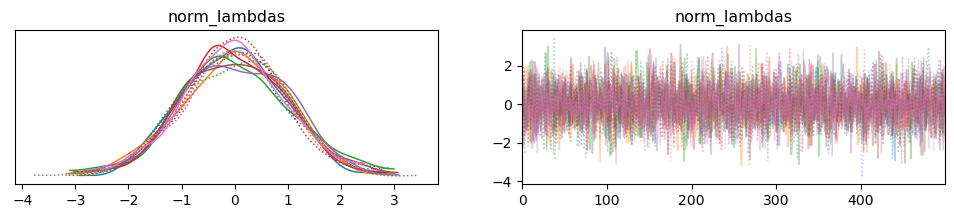

In [7]:
az.plot_trace(inf_data)
# plt.savefig("latex/figures/inference_trace.pdf")
plt.show()

In [8]:
posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))
posterior_values = backtransform(posterior_values.norm_lambdas.values.transpose())

In [9]:
for i in tqdm(range(1)):
    laplace_approx, lap_losses, fails = mei.laplace_approximation_normal_prior(dp_suff_stat, n, sigma_DP, max_ent_dist, max_retries=3, max_iters=500)
    if fails > 0: print(fails)

laplace_mean = laplace_approx.loc
laplace_cov = laplace_approx.covariance_matrix

100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


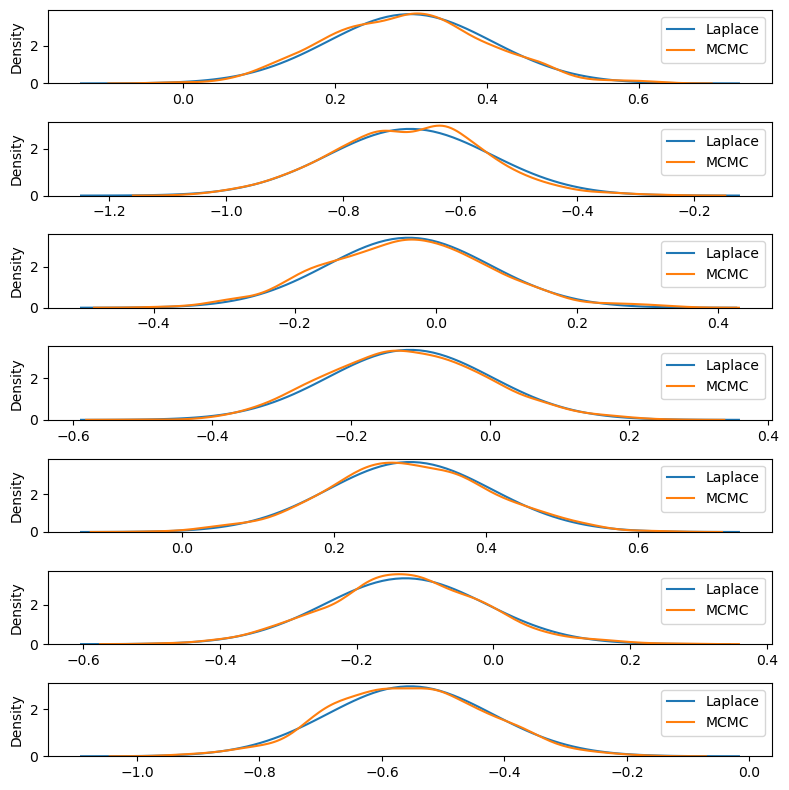

In [10]:
fig, ax = plt.subplots(laplace_mean.shape[0], figsize=(8, 8))
for i in range(laplace_mean.shape[0]):
    xs = torch.linspace(-1, 1, 100) * torch.sqrt(laplace_cov[i, i]) * 4 + laplace_mean[i]
    ys1 = torch.exp(torch.distributions.Normal(laplace_mean[i], torch.sqrt(laplace_cov[i, i])).log_prob(xs))
    ax[i].plot(xs.detach().numpy(), ys1.detach().numpy(), label="Laplace")
    sns.kdeplot(posterior_values[:, i], ax=ax[i], label="MCMC")
    ax[i].legend()

plt.tight_layout()
# plt.savefig("latex/figures/inference-method-comparison-small-queries.pdf")

In [11]:
n_syn_datasets = 600
n_syn_dataset = n
posterior_sample = laplace_approx.sample((n_syn_datasets,)).numpy()
syn_datasets = mei.generate_synthetic_data(posterior_sample, n_syn_dataset, max_ent_dist)

100%|██████████| 600/600 [00:00<00:00, 3225.47it/s]


In [12]:
single_syn_df = pd.DataFrame(max_ent_dist.sample(laplace_mean, n_syn_dataset).numpy(), columns=["X1", "X2", "X3"])

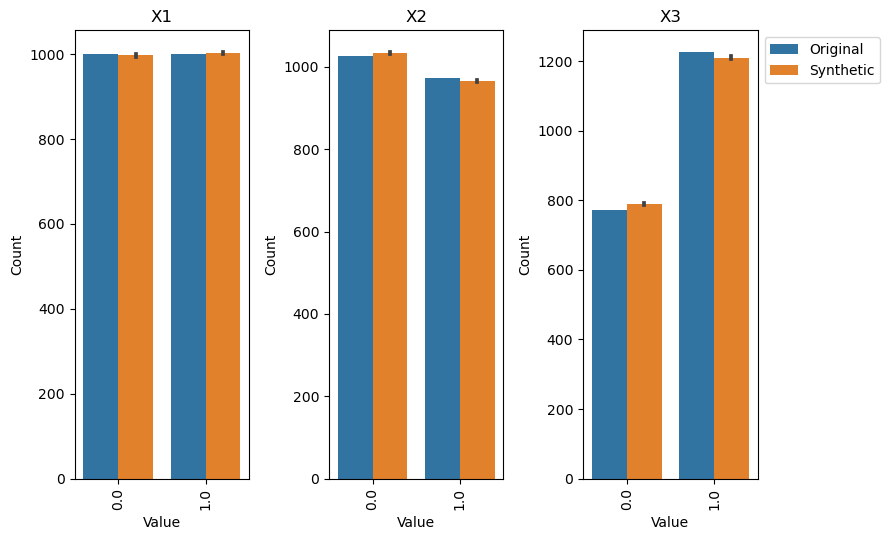

In [13]:
data_df = pd.DataFrame(data.numpy(), columns=["X1", "X2", "X3"])
syn_data_dfs = [pd.DataFrame(syn_data, columns=["X1", "X2", "X3"]) for syn_data in syn_datasets]
plot_dataframe_marginal_comparison(data_df, syn_data_dfs, estimator=np.median)

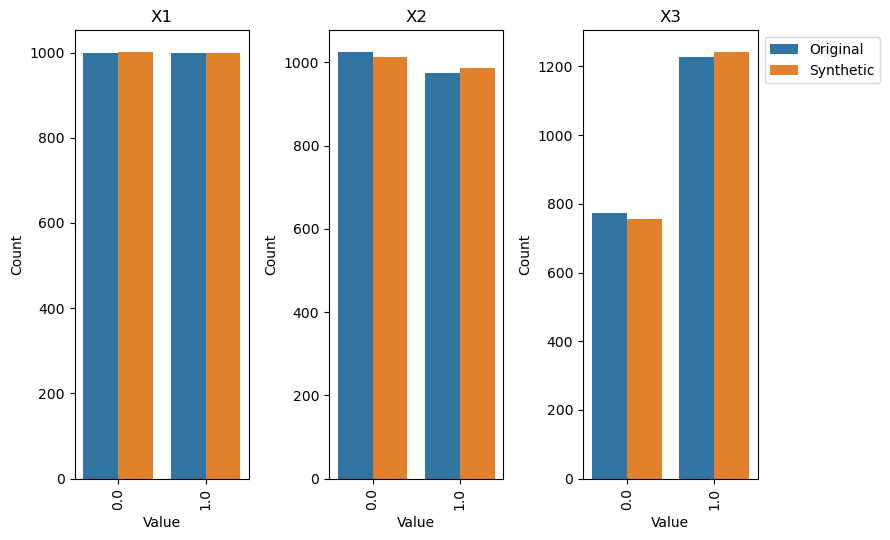

In [14]:
plot_dataframe_marginal_comparison(data_df, [single_syn_df])

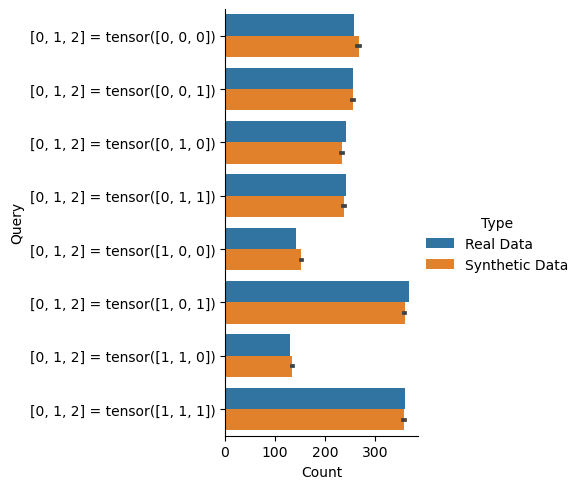

In [15]:
workload = marginal_query.all_marginals([(0, 1, 2)], data_gen.values_by_feature)
workload_values = workload(data).sum(dim=0)
syn_df_query_values = [torch.sum(workload(torch.tensor(syn_data)), axis=0) for syn_data in syn_datasets]

plot_workload_comparison(workload, workload_values, syn_df_query_values)

In [16]:
single_syn_data = syn_datasets.reshape((1, -1, 3))
q_single, u_single, conf_ints_single = lr.logistic_regression(single_syn_data, add_constant=False, return_intervals=True, conf_levels=[0.95], weight=n/1200000)
conf_ints_single

{0.95: array([[[ 0.73581283,  1.04599932],
         [-0.10314102,  0.19827585]]])}

In [17]:
q, u = lr.logistic_regression(syn_datasets, add_constant=False)
rubin.conf_int(q[:,0], u[:,0], 0.95)

(0.7231141285469971, 1.0646371416322689)

In [18]:
rubin.conf_int(q[:,1], u[:,1], 0.95)

(-0.11022626636590918, 0.2053392773444874)

In [19]:
rubin.non_negative_conf_int(q[:,0], u[:,0], 0.95, n_syn_dataset, n)

(0.7231141285469971, 1.0646371416322689)

In [20]:
rubin.non_negative_conf_int(q[:,1], u[:,1], 0.95, n_syn_dataset, n)

(-0.11022626636590918, 0.2053392773444874)